In [1]:
import torch
from torch import nn
from torch.autograd.functional import jacobian
import data_generation as data
import Systems
import numpy as np
from NN import Main_Network
import matplotlib.pyplot as plt
import training_data
#from Main_NN import Main_Network
from Trainer import Trainer
import scipy.io as spio
from torch.optim.lr_scheduler import ReduceLROnPlateau
#from Models import *
from Simulator import simulate, simulate_NA
import Observer
from Observer import System_z, Observer
import torch.nn.functional as F
#torch.manual_seed
#np.random.seed(0)

In [2]:
# --------------------- Reverse Duffing Oscillator --------------------- 

limits = np.array([[-1,1], [-1,1]])    # Sample space
a = 0   # start
b = 50  # end
N = 1000          # Number of intervals for RK4
num_ic = 50        # Number of initial conditions to be sampled
# M = np.diag([-1,-2,-3])    # Choose M matrix
# K = np.array([[1,1,1]]).T    # Choose K matrix

# M = np.array([[-6.8579, -0.0802, -0.4653],
#                [-0.0802, -6.0525,  -0.0459],
#                [-0.4653, -0.0459, -6.3108]])
            
# K = np.array([[0.5647, 0.0557, 0.3231]]).T

mat = spio.loadmat('/Applications/Programming/Machine Learning/DF Internship/MK_data/Duffing_ML_corrected.mat', squeeze_me=True)
M = mat['M']
K = np.expand_dims(mat['L'], axis = 0).T

revduff = Systems.RevDuff(limits, add_noise=False)

dataset = training_data.DataSet(revduff, M, K, a, b, N, num_ic)
#dataset.normalize()
trainset = torch.utils.data.DataLoader(dataset, batch_size = 32, shuffle = True)

In [3]:
# --------------------- Non-Autonomous Reverse Duffing Oscillator --------------------- 
def u(t):
    return 1e-3 + 9.99*1e-5*t

limits = np.array([[-1,1], [-1,1]])    # Sample space
a = 0   # start
b = 50  # end
N = 1000          # Number of intervals for RK4
num_ic = 50        # Number of initial conditions to be sampled
M = np.diag([-1,-2,-3])    # Choose M matrix
K = np.array([[1,1,1]]).T    # Choose K matrix

revduff_na = Systems.RevDuff_NA(limits, u)      # Create system

dataset = training_data.DataSet(revduff_na, M, K, a, b, N, num_ic)
dataset.normalize()
trainset = torch.utils.data.DataLoader(dataset, batch_size = 32, shuffle = True)

In [2]:
# --------------------- Network SIS ---------------------
np.random.seed(1)

a = [1]*10    # 10 dimensional system

B = np.diag(a)*np.random.rand(10,10)

G = np.diag(a)*np.random.rand(10,10)

#A = np.diag(a)
#del a[-1]
#A = (A + np.diag(a, 1) + np.diag(a, -1))*np.random.rand(10,10)
A = np.random.randint(2, size=(10,10))*np.random.rand(10,10)

C = np.concatenate((np.eye(3),np.zeros((3,7))), axis = 1)

limits = np.concatenate((np.zeros([10,1]), np.ones([10,1])), axis = 1)    # Sample space
a = 0   # start
b = 50  # end
N = 1000        # Number of intervals for RK4
num_ic = 50       # Number of initial conditions to be sampled

# Load controllable pair (M,K) from MATLAB
mat = spio.loadmat('/Users/johncao/Documents/MATLAB/MK.mat', squeeze_me=True)
M = mat['M']
K = mat['K']

SIS = Systems.SIS(limits,A,B,G,C)    # Create and initiate the system

train = training_data.DataSet(SIS, M, K, a, b, N, limits, num_ic)
trainset = torch.utils.data.DataLoader(train, batch_size = 32, shuffle = True)

(50, 1001, 3)


In [2]:
# --------------------- Van der Pol Oscillator ---------------------

limits = np.array([[-1,1], [-1,1]])    # Sample space
a = 0   # start
b = 50  # end
N = 1000          # Number of intervals for RK4
num_ic = 50        # Number of initial conditions to be sampled
M = np.diag([-1,-2,-3])    # Choose M matrix
K = np.array([[1,1,1]]).T    # Choose K matrix
vdp = Systems.VdP(limits, 3)

dataset = training_data.DataSet(vdp, M, K, a, b, N, num_ic)
#dataset.normalize()
trainset = torch.utils.data.DataLoader(dataset, batch_size = 32, shuffle = True)


In [2]:
# --------------------- Non-Autonomous Van der Pol Oscillator ---------------------

# Excitation
def u(t):
    return 1e-3 + 9.99*1e-5*t

limits = np.array([[-1,1], [-1,1]])    # Sample space
vdp_na = Systems.VdP_NA(limits, u, 1)
a = 0   # start
b = 50  # end
N = 1000          # Number of intervals for RK4
num_ic = 50        # Number of initial conditions to be sampled
M = np.diag([-1,-2,-3])    # Choose M matrix
K = np.array([[1,1,1]]).T    # Choose K matrix

dataset = training_data.DataSet(vdp_na, M, K, a, b, N, num_ic)
#dataset.normalize()
trainset = torch.utils.data.DataLoader(dataset, batch_size = 32, shuffle = True)


In [2]:
# --------------------- Polynomial ---------------------

limits = np.array([[-1,1], [-1,1]])    # Sample space
a = 0   # start
b = 50  # end
N = 1000        # Number of intervals for RK4
num_ic = 50        # Number of initial conditions to be sampled
M = np.diag([-1,-2,-3])    # Choose M matrix
K = np.array([[1,1,1]]).T    # Choose K matrix
poly = Systems.Polynomial(limits)

train = training_data.DataSet(poly, M, K, a, b, N, limits, num_ic)
trainset = torch.utils.data.DataLoader(train, batch_size = 32, shuffle = True)

In [ ]:
# --------------------- Robot Arm ---------------------

limits = np.concatenate((np.zeros([4,1]), np.ones([4,1])*2), axis = 1)    # Sample space
a = 0   # start
b = 50  # end
N = 1000        # Number of intervals for RK4
num_ic = 50        # Number of initial conditions to be sampled

A = np.array([[0, 1, 0, 0],
            [-48.6, -1.25, 48.6, 0],
            [0, 0, 0, 1],
            [19.5, 0, -19.5, 0]])
             
B = np.array([[0, 21.6, 0, 6]]).T
             
C = np.array([[1, 0, 0, 0],
            [0, 1, 0, 0]])

f = lambda x: np.array([0, 0, 0, -3.33*np.sin(x[2])])

u = lambda t: np.sin(2*np.pi*t)    # input

# Load controllable pair (M,K) from MATLAB
mat = spio.loadmat('/Users/johncao/Documents/MATLAB/MK/MK_robot', squeeze_me=True)
M = mat['M']
K = mat['K']
print(K)
robot = Systems.RobotArm(limits, A, B, C, f, u)

train = training_data.DataSet(robot, M, K, a, b, N, limits, num_ic)
trainset = torch.utils.data.DataLoader(train, batch_size = 32, shuffle = True)

In [2]:
# Chua's Circuit

alpha = 11.81
beta = 14.9
gamma = 0.29
limits = np.array([[-0.1,0.1], [-0.1,0.1], [-0.1,0.1]])    # Sample space
a = 0   # start
b = 50  # end
N = 1000        # Number of intervals for RK4
num_ic = 50
M = np.diag([-1,-2,-3,-4])    # Choose M matrix
K = np.array([[1,1,1,1]]).T    # Choose K matrix
chua = Systems.Chua(limits, alpha, beta, gamma, -1.14, -0.71)

dataset = training_data.DataSet(chua, M, K, a, b, N, num_ic)
dataset.normalize()
trainset = torch.utils.data.DataLoader(dataset, batch_size = 32, shuffle = True)

In [3]:
# Rössler's System

a0 = 0.2
b0 = 0.2
c0 = 5

a = 0   # start
b = 50  # end
N = 1000        # Number of intervals for RK4
num_ic = 50
mat = spio.loadmat('/Applications/Programming/Machine Learning/DF Internship/MK_data/MK_Rossler', squeeze_me=True)
M = mat['M']
K = mat['K'].reshape(4,1)
limits = limits = np.array([[-1,1], [-1,1], [-1,1]])    # Sample space
rossler = Systems.Rossler(limits, a0, b0, c0)

dataset = training_data.DataSet(rossler, M, K, a, b, N, num_ic)
#dataset.normalize()
trainset = torch.utils.data.DataLoader(dataset, batch_size = 32, shuffle = True)

In [2]:
# SIR

beta = 0.5
gamma = 0.05
limits = limits = np.array([[0,1], [0,1], [0,1]])    # Sample space

mat = spio.loadmat('/Applications/Programming/Machine Learning/DF Internship/MK_data/MK_SIR', squeeze_me=True)
M = mat['M']
K = mat['K']

a = 0   # start
b = 50  # end
N = 1000        # Number of intervals for RK4
num_ic = 50

sir = Systems.SIR(limits, beta, gamma, 1)

train = training_data.DataSet(sir, M, K, a, b, N, limits, num_ic)
trainset = torch.utils.data.DataLoader(train, batch_size = 32, shuffle = False)

In [3]:
# --------------------- Training Setup ---------------------

torch.manual_seed(5)

x_size = dataset.system.x_size
z_size = dataset.system.z_size
num_hidden = 10
hidden_size = 50
activation = F.relu

main_net = Main_Network(x_size, z_size, num_hidden, hidden_size, activation)
epochs = 15
learning_rate = 0.001
batch_size = 32
optimizer = torch.optim.Adam(main_net.parameters(), lr = learning_rate)
scheduler = ReduceLROnPlateau(optimizer, mode = 'min', factor = 0.1, patience = 2, threshold = 0.0001, verbose = True)
loss_fn = nn.MSELoss(reduction = 'mean')

trainer = Trainer(dataset, epochs, optimizer, main_net, loss_fn, batch_size, scheduler = scheduler)

Device: cpu


In [4]:
trainer.train(with_pde = False)

Epoch: 1 Loss: 0.12562938034534454
Epoch: 2 Loss: 0.05812307819724083
Epoch: 3 Loss: 0.011087382212281227
Epoch: 4 Loss: 0.0021643892396241426
Epoch: 5 Loss: 0.0018590576946735382
Epoch: 6 Loss: 0.0014429778093472123
Epoch: 7 Loss: 0.0015298008220270276
Epoch: 8 Loss: 0.00127288862131536
Epoch: 9 Loss: 0.0011445009149610996
Epoch: 10 Loss: 0.0009738952503539622
Epoch: 11 Loss: 0.0011472799815237522
Epoch: 12 Loss: 0.0009028842323459685
Epoch: 13 Loss: 0.0008620979497209191
Epoch: 14 Loss: 0.000732773682102561
Epoch: 15 Loss: 0.0006222020019777119
Epoch: 16 Loss: 0.0006696024793200195
Epoch: 17 Loss: 0.000555574195459485
Epoch: 18 Loss: 0.0005400005029514432
Epoch: 19 Loss: 0.00050177430966869
Epoch: 20 Loss: 0.0004694359377026558
Epoch: 21 Loss: 0.00046105077490210533
Epoch: 22 Loss: 0.00042797980131581426
Epoch: 23 Loss: 0.00046419494901783764
Epoch: 24 Loss: 0.0003717615909408778
Epoch: 25 Loss: 0.0003817768592853099
Epoch: 26 Loss: 0.0004140889795962721
Epoch: 27 Loss: 0.00032210239

In [6]:
File = '/Applications/Programming/Machine Learning/DF Internship/Models/RevDuff/Noise/50ic_1000N_-1_1_15ep_SEED5_lr0.001_bs32'  
torch.save(main_net, File)

In [26]:
def sim_error(ic, model, mean_z, std_z, mean_x, std_x):
    limits = np.array([[-10,10], [-10,10]])    # Sample space
    a = 0
    b = 100
    N = 5000

    #sys = Systems.RevDuff(limits)
    #sys = Systems.VdP(limits,3)
    #sys = Systems.Polynomial(limits)
    #sys =  Systems.Chua(limits, 11.81, 14.9, 0.29, -1.14, -0.71)
    sys = Systems.Rossler(limits, 0.2, 0.2, 5)
    M = np.diag([-1,-2,-3,-4])    # Choose M matrix
    K = np.array([[1,1,1,1]]).T    # Choose K matrix
    error = 0
    for idx, ic in enumerate(ic):
        x, y, t = sys.generate_data(ic, a, b, N)
        x = np.reshape(x, (N+1,3))
        noise = np.random.normal(0, 1, (y.shape[0], y.shape[1]))    # Adding Noise
        y = y + noise
        z = data.KKL_observer_data(M, K, y, a, b, N)
        z = torch.from_numpy(z).view(N+1,4).float()
        z = ((z - mean_z) / std_z).float()      # Normalize input
        with torch.no_grad():
            x_hat = model.net2(z)
            x_hat = x_hat*std_x + mean_x
            x1_hat = x_hat[:,0]
            x2_hat = x_hat[:,1]
            x3_hat = x_hat[:,2]
            
        x1 = torch.from_numpy(x[:,0])
        x2 = torch.from_numpy(x[:,1])
        x3 = torch.from_numpy(x[:,2])
        x = torch.from_numpy(x)
        error += torch.abs(x2-x2_hat)
    
    error = error / (idx+1)
    
    return t, error

In [2]:
#np.random.seed(0)
ic = np.random.rand(1,2)
#ic = np.array([[3,3]])
#sys =  Systems.Chua(1, 11.81, 14.9, 0.29, -1.14, -0.71)
sys = chua
model1 = torch.load('/Applications/Programming/Machine Learning/DF Internship/Models/random_stuff/50ic_1000N_-1_1_15ep_SEED_NoPde_lr0.0001_bs32_scheduler' )
#model2 = torch.load('/Applications/Programming/Machine Learning/DF Internship/Models/random_stuff/50ic_1000N_-1_1_15ep_SEED_NoPde_lr0.0001_bs32_scheduler' )
#x, x_hat, t, error = simulate(sys, main_net, a = 0, b = 50, N = 5000, M = M, K = K, ic = ic, mean = dataset.mean_z, std = dataset.std_z)
x, x_hat, t1, error1 = simulate(sys, main_net, a = 0, b = 50, N = 5000, M = M, K = K, ic = ic, mean = 1, std = 1)
#x2, x_hat2, t2, error2 = simulate(sys, model2, a = 0, b = 50, N = 5000, M = M, K = K, ic = ic, mean = 1, std = 1)
#x_hat = x_hat*dataset.std_x + dataset.mean_x
#x1 = torch.from_numpy(x[:,0])
#x2 = torch.from_numpy(
# x[:,1])
#x3 = torch.from_numpy(x[:,2])

#x1_hat = x_hat[:,0]
#x2_hat = x_hat[:,1]
#x3_hat = x_hat[:,2]

fig = plt.figure(figsize = (10,10), facecolor = 'w')

p1, = plt.plot(x_hat[:,0], x_hat[:,1])
p2, = plt.plot(x[:,0], x[:,1])

#p1, = plt.plot(x_hat[:,0], x_hat[:,1])
#p2, = plt.plot(x[:,0], x[:,1])

#ax = plt.axes(projection = '3d')
#p1, = ax.plot3D(x_hat[:,0], x_hat[:,1],x_hat[:,2] )
#p2, = ax.plot3D(x[:,0], x[:,1], x[:,2])

#plt.legend([p1, p2], ['Estimate', 'Ground Truth'])
#plt.title('Van der Pol Oscillator')
plt.show()
#p1, = plt.plot(x_hat2[:,0], x_hat2[:,1])
#p2, = plt.plot(x2[:,0], x2[:,1])

NameError: name 'vdp_na' is not defined

In [7]:
fig.savefig('/Applications/Programming/Machine Learning/DF Internship/Plots/random/Normalized_Rossler', dpi=300, transparent = False, bbox_inches = 'tight', facecolor = 'w')

In [3]:
# Plot error

model1 = torch.load('/Applications/Programming/Machine Learning/DF Internship/Models/random_stuff/50ic_1000N_-1_1_15ep_SEED_NoPde_lr0.0001_bs32_scheduler' ) # No Pde

ic_test = np.random.uniform(-1, 1, (50,1,2))
err = 0
for idx, ic in enumerate(ic_test):
    x, x_hat, t, error = simulate(sys, main_net, a = 0, b = 50, N = 5000, M = M, K = K, ic = ic, mean = 1, std = 1)
    err += error
print(error/(idx + 1))
plt.figure(figsize = (10,10), facecolor = 'w')
plt.plot(t,error)
#plt.legend([p1, p2], ['With Pde', 'Without Pde']) 
# plt.xlabel('Time')
# plt.ylabel('Average Error over 50 Trajectories')
# plt.title('Rossler x2')
# plt.show()
#fig.savefig('/Applications/Programming/Machine Learning/DF Internship/Plots/Rossler/Error_Rossler_x2', dpi=300, transparent = False, bbox_inches = 'tight', facecolor = 'w')

NameError: name 'main_net' is not defined

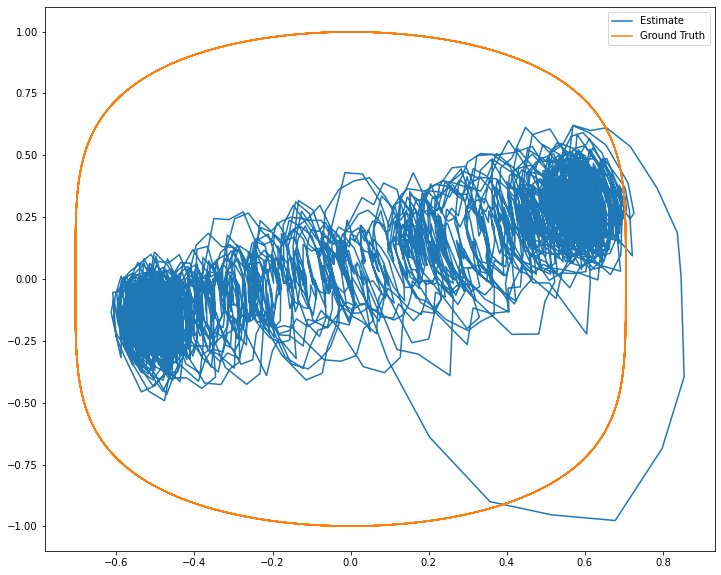

In [12]:
def u(t):
    #return 0.8*np.sin(0.1*t)
    return 0.45*np.cos(0.9*t)

def u0(t):
    return 1e-3 + 9.99*1e-5*t

#np.random.seed(2)
limits = np.array([[-1,1], [-1,1]])    # Sample space
g = np.array([[0,1]]).T
#model1 = RevDuff_noise['model1']       # No Pde
#model2 = RevDuff_noise['model2']       # Pde

# mean = dataset.mean_z
# std = dataset.std_z
#sys = Systems.VdP_NA(limits, u, 1)
#sys = Systems.RevDuff_NA(limits, u)

sys = Systems.RevDuff(limits, add_noise=False)
z_sys = System_z(M, K, sys)
observer1 = Observer(sys, z_sys, main_net)
#observer2 = Observer(sys, z_sys, main_net)

ic = np.random.rand(1,2)
#ic = np.array([[0.1, 0.6]])

x1, x1_hat, t1, error1 = observer1.simulate(0, 50, 5000, ic, 0,0, add_noise=True)
#x1_hat = (x1_hat*dataset.std_x) + dataset.mean_x
#x2, x2_hat, t2, error2 = observer2.simulate_NA(0, 50, 5000, ic, u0, g)

# x1, x1_hat, t1, error1 = simulate_NA(sys, ic, M, K, 0, 50, 5000, u0, T1, T1_inv,g)
# x2, x2_hat, t2, error2 = simulate_NA(sys, ic, M, K, 0, 50, 5000, u0, T2, T2_inv,g)

fig = plt.figure(figsize = (12,10), facecolor='w')
p1, = plt.plot(x1_hat[:,0], x1_hat[:,1])
p2, = plt.plot(x1[:,0], x1[:,1])
plt.legend([p1, p2], ['Estimate', 'Ground Truth'])
plt.show()

# fig = plt.figure(figsize = (15,10), facecolor='w')
# p1, = plt.plot(t2, x2_hat[:,1])
# p2, = plt.plot(t2, x2[:,1])
# plt.legend([p1, p2], ['Estimate', 'Ground Truth'])
# plt.show()
#fig = plt.figure(figsize = (15,10), facecolor='w')
#plt.plot(t, x_hat[:,0])
#plt.plot(t, x[0][:,0])
#plt.show()

# fig = plt.figure(figsize = (15,10), facecolor='w')
# ax = fig.add_subplot(projection='3d')
# ax.scatter3D(x1_hat[:,0], x1_hat[:,1],x1_hat[:,2])
# ax.scatter3D(x1[:,0], x1[:,1],x1[:,2])
# plt.show()

In [8]:
fig.savefig('/Applications/Programming/Machine Learning/DF Internship/Plots/RevDuff_noise/Old_M', dpi=300, transparent = False, bbox_inches = 'tight', facecolor = 'w')

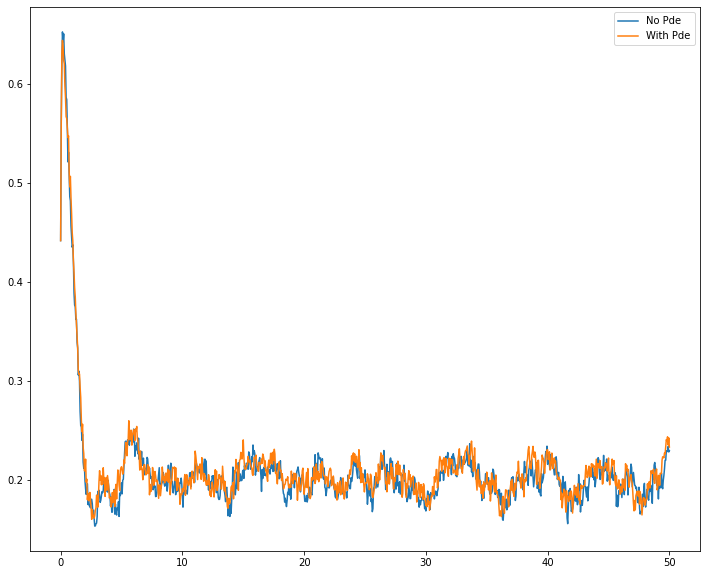

In [26]:
ic_samples = np.random.uniform(-1, 1, (50,1,2))
error1, t1 = observer1.get_average_error(a, b, N, ic_samples, add_noise=True)
error2, t2 = observer2.get_average_error(a, b, N, ic_samples, add_noise=True)
fig = plt.figure(figsize = (12,10), facecolor='w')
p1, = plt.plot(t1, error1[:,1])
p2, = plt.plot(t1, error2[:,1])
plt.legend([p1, p2], ['No Pde', 'With Pde'])
plt.show()

In [18]:
main_net

Main_Network(
  (net1): NN(
    (layers): ModuleList(
      (0): Linear(in_features=2, out_features=50, bias=True)
      (1): Linear(in_features=50, out_features=50, bias=True)
      (2): Linear(in_features=50, out_features=50, bias=True)
      (3): Linear(in_features=50, out_features=50, bias=True)
      (4): Linear(in_features=50, out_features=50, bias=True)
      (5): Linear(in_features=50, out_features=50, bias=True)
      (6): Linear(in_features=50, out_features=50, bias=True)
      (7): Linear(in_features=50, out_features=50, bias=True)
      (8): Linear(in_features=50, out_features=50, bias=True)
      (9): Linear(in_features=50, out_features=50, bias=True)
      (10): Linear(in_features=50, out_features=3, bias=True)
    )
  )
  (net2): NN(
    (layers): ModuleList(
      (0): Linear(in_features=3, out_features=50, bias=True)
      (1): Linear(in_features=50, out_features=50, bias=True)
      (2): Linear(in_features=50, out_features=50, bias=True)
      (3): Linear(in_features=